In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.cluster.hierarchy import dendrogram, linkage
from tqdm import tqdm

# plt.rc('font', family='Malgun Gothic') # windows
plt.rc('font', family='AppleGothic') # mac
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_pickle('../data/KOSPI_price_2011-2021_with_marcap.pickle')
df = df.loc[:, ["Name", "Date", "Close", "Marcap"]].dropna()

benchmark_df = df[df.Name == "TIGER 200"].reset_index(drop=True).set_index("Date")

df = df[~df.Name.str.contains("인버스")].reset_index(drop=True)
df = df.set_index("Date")
df.head()

,Name,Close,Marcap
Date,,,
2015-08-21,AJ네트웍스,7100.0,3.324383e+11
2015-08-24,AJ네트웍스,6480.0,3.034085e+11
2015-08-25,AJ네트웍스,6220.0,2.912347e+11
2015-08-26,AJ네트웍스,7090.0,3.319701e+11
2015-08-27,AJ네트웍스,7570.0,3.544448e+11


In [2]:
benchmark_df.head()

,Name,Close,Marcap
Date,,,
2011-06-01,TIGER 200,23682.0,3.234843e+09
2011-06-02,TIGER 200,23332.0,1.189155e+10
2011-06-03,TIGER 200,23349.0,1.268794e+10
2011-06-07,TIGER 200,23203.0,5.391031e+09
2011-06-08,TIGER 200,22973.0,8.934958e+09


In [3]:
class RiskParity:
    def __init__(self, df):
        self.df = df
        self.firm_list = self.df.columns.values
        self.cov_mat = df.cov().values
        self.std = df.std()
        
        self.initial_weights = np.repeat(1 / self.cov_mat.shape[0], self.cov_mat.shape[0])
        self.constraints = ({"type": "eq", "fun": RiskParity.weight_summation_constraint,
                            "type": "ineq", "fun": RiskParity.weight_bound_constraint})
        self.options = {"ftol": 1e-20, "maxiter": 1000}
        
        
    def optimize(self):
        self.results = minimize(fun=RiskParity.objective_function,
                                x0=self.initial_weights, 
                                method='SLSQP', 
                                constraints=self.constraints,
                                options=self.options,
                                args=self.cov_mat)

    @property
    def get_weights(self):
        return self.results.x
    
    
    @staticmethod
    def objective_function(x, cov_mat):
        variance = x.T @ cov_mat @ x
        sigma = variance ** 0.5
        mrc = 1 / sigma * (cov_mat @ x)
        rc = x * mrc
        a = np.reshape(rc, (len(rc), 1))
        risk_diff = a - a.T
        squared_risk_diff_summation = np.sum(np.square(np.ravel(risk_diff)))

        return squared_risk_diff_summation


    @staticmethod
    def weight_summation_constraint(x):
        return x.sum() - 1.0


    @staticmethod
    def weight_bound_constraint(x):
        return x
    
    
    def plot(self):
        plt.figure(figsize=(15, 10))

        plt.subplot(2,1,1)
        plt.title("포트폴리오 비중")
        plt.bar(self.firm_list, self.results.x)
        
        plt.subplot(2,1,2)
        plt.title("종목 별 변동성")
        plt.bar(self.firm_list, self.std)


In [4]:
def get_back_data(start_date, end_date, df, num_asset=200):
    firm_list = get_largest_firms(start_date, end_date, df, num_asset)
    back_data = df.reset_index().pivot(index="Date", columns="Name", values="Close").loc[start_date:end_date, firm_list]
    
    for i in back_data.columns[back_data.isnull().any(axis=0)]:
        back_data[i].fillna(back_data[i].mean(),inplace=True)
    
    back_data_pct = back_data.pct_change(fill_method ='ffill') * 100

    return back_data, back_data_pct


def get_largest_firms(start_date, end_date, df, n_count=200):
    firm_list = df.loc[start_date:end_date, ["Name", "Marcap"]].groupby("Name").mean().sort_values(by="Marcap", ascending=False).index[:n_count]
    
    return firm_list


def generate_portfolio(starting_budget, weights, stock_prices):
    holding_amount = starting_budget * weights // stock_prices.values   
    portfolio_value = (holding_amount * stock_prices).values.sum()
    remaining_budget = starting_budget - portfolio_value   
    
    return remaining_budget, holding_amount, portfolio_value


def calc_valuation(holding_amount, portfolio_value, stock_prices):
    updated_portfolio_value = (holding_amount * stock_prices).values.sum()
    daily_performance = np.log(updated_portfolio_value / portfolio_value + 0.0000001)
    
    return updated_portfolio_value, daily_performance


def save_daily_results(performance_results, today, portfolio_value, daily_performance):
    performance_results['Date'].append(today)
    performance_results['portfolio_value'].append(portfolio_value)
    performance_results["performance"].append(daily_performance)
    
    return performance_results


def performance_metrics(ERCRP_performance_results, HRP_performance_results, benchmark_performance):
    ERCRP_sharp_ratio = round(ERCRP_performance_results.performance.mean() / ERCRP_performance_results.performance.std() * 100, 2)
    HRP_sharp_ratio = round(HRP_performance_results.performance.mean() / HRP_performance_results.performance.std() * 100, 2)
    benchmark_sharp_ratio = round(benchmark_performance.mean() / benchmark_performance.std() * 100, 2)
    
    ERCRP_annual_average_return = round(ERCRP_performance_results.performance.mean() * 252 * 100, 2)
    HRP_annual_average_return = round(HRP_performance_results.performance.mean() * 252 * 100, 2)
    benchmark_annual_average_return = round(benchmark_performance.mean() * 252 * 100, 2)
    
    ERCRP_annual_average_risk = round(ERCRP_performance_results.performance.std() * 252, 2)
    HRP_annual_average_risk = round(HRP_performance_results.performance.std() * 252, 2)
    benchmark_anuual_average_risk = round(benchmark_performance.std() * 252, 2)
    
    metric_df = pd.DataFrame({"sharp_ratio": [ERCRP_sharp_ratio, HRP_sharp_ratio, benchmark_sharp_ratio],
                              "annual_average_return": [ERCRP_annual_average_return, HRP_annual_average_return, benchmark_annual_average_return],
                              "annual_average_risk": [ERCRP_annual_average_risk, HRP_annual_average_risk, benchmark_anuual_average_risk]},
                              index=['ERCRP', "HRP", "Benchmark"])
    
    return metric_df
    

In [5]:
class HRP:
    def __init__(self, df):
        self.df = df
        self.cov_mat = self.df.cov()
        
    
    def optimize(self):
        self.calc_distance()
        self.generate_cluster()
        self.get_quasi_diag()
        self.weights = self.get_rec_bipart()
        self.weights = self.weights.sort_index().values
        
        
    def calc_distance(self):
        corr_mat = self.df.corr()
        self.distance_mat = np.sqrt(0.5 * (1 - corr_mat))
        
        
    def generate_cluster(self):
        self.link = linkage(self.distance_mat, 'single')
        self.Z = pd.DataFrame(self.link)
        
    
    def get_quasi_diag(self):
        self.link = self.link.astype(int)
        self.sort_ix = pd.Series([self.link[-1, 0], self.link[-1, 1]]) 
        num_items = self.link[-1, 3]
        
        while self.sort_ix.max() >= num_items:
            self.sort_ix.index = range(0, self.sort_ix.shape[0] * 2, 2)

            df0 = self.sort_ix[self.sort_ix >= num_items]

            i = df0.index
            j = df0.values - num_items

            self.sort_ix[i] = self.link[j, 0]

            df0 = pd.Series(self.link[j, 1], index=i + 1)

            self.sort_ix = self.sort_ix.append(df0)
            self.sort_ix = self.sort_ix.sort_index()

            self.sort_ix.index = range(self.sort_ix.shape[0])
       
    
    def get_rec_bipart(self):
        weights = pd.Series(1, index=self.sort_ix)
        c_items = [self.sort_ix]        
        
        while len(c_items) > 0:
            c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                       ((0, len(i)/2),(len(i)/2, len(i))) if len(i) > 1]

            for i in range(0, len(c_items), 2):    
                c_items0 = c_items[i]
                c_items1 = c_items[i + 1]

                cluster_var0 = self.get_cluster_var(self.cov_mat, c_items0)
                cluster_var1 = self.get_cluster_var(self.cov_mat, c_items1)

                alpha = 1 - cluster_var0 / (cluster_var0 + cluster_var1)

                weights[c_items0] *= alpha
                weights[c_items1] *= 1 - alpha

        return weights
        
    
    def get_cluster_var(self, cov_mat, c_items):
        cov_mat_ = cov_mat.iloc[c_items, c_items]
        
        ivp = 1./ np.diag(cov_mat_)
        ivp /= ivp.sum()

        w_ = ivp.reshape(-1,1)
        cluster_var = np.dot(np.dot(w_.T, cov_mat_), w_)[0,0]
        
        return cluster_var
    

In [6]:
num_asset = 30
rebalancing_period = 21

whole_data = df.reset_index().pivot(index="Date", columns="Name", values="Close").loc["2011-06":"2021-06"]

ERCRP_performance_results = {"Date": [], "portfolio_value": [], "performance": []}
HRP_performance_results = {"Date": [], "portfolio_value": [], "performance": []}

ERCRP_remaining_budget = 100000000
HRP_remaining_budget = 100000000

ERCRP_portfolio_value = 0
HRP_portfolio_value = 0

ERCRP_daily_performance = 0
HRP_daily_performance = 0

for date_number, (today, stock_prices) in enumerate(tqdm(whole_data.iterrows())):
    stock_prices = stock_prices.fillna(0)
    if date_number < 126:
        continue
    
    if date_number % rebalancing_period == 0:
        ERCRP_remaining_budget += ERCRP_portfolio_value
        HRP_remaining_budget += HRP_portfolio_value
        
        start_date = whole_data.index.strftime('%Y-%m-%d').astype(str)[date_number - 121]
        end_date = whole_data.index.strftime('%Y-%m-%d').astype(str)[date_number - 1]
        
        back_data, back_data_pct = get_back_data(start_date, end_date, df, num_asset=num_asset)
        firm_list = back_data.columns.values
        rp_portfolio = RiskParity(back_data_pct)
        rp_portfolio.optimize()
        
        hrp_portfolio = HRP(back_data_pct)
        hrp_portfolio.optimize()
        
        ERCRP_remaining_budget, ERCRP_holding_amount, ERCRP_portfolio_value = generate_portfolio(ERCRP_remaining_budget, rp_portfolio.get_weights, stock_prices[firm_list])
        HRP_remaining_budget, HRP_holding_amount, HRP_portfolio_value = generate_portfolio(HRP_remaining_budget, hrp_portfolio.weights, stock_prices[firm_list])
    else:
        ERCRP_portfolio_value, ERCRP_daily_performance = calc_valuation(ERCRP_holding_amount, ERCRP_portfolio_value, stock_prices[firm_list])
        HRP_portfolio_value, HRP_daily_performance = calc_valuation(HRP_holding_amount, HRP_portfolio_value, stock_prices[firm_list])
        
    ERCRP_performance_results = save_daily_results(ERCRP_performance_results, today, ERCRP_portfolio_value, ERCRP_daily_performance)
    HRP_performance_results = save_daily_results(HRP_performance_results, today, HRP_portfolio_value, HRP_daily_performance)
      
ERCRP_performance_results = pd.DataFrame.from_dict(ERCRP_performance_results)
HRP_performance_results = pd.DataFrame.from_dict(HRP_performance_results)


0it [00:00, ?it/s]/var/folders/nw/x1lqw0rx1mj698bqcgqxhk880000gn/T/ipykernel_5790/1186464116.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.link = linkage(self.distance_mat, 'single')
2485it [02:45, 14.98it/s]


In [7]:
benchmark_index = benchmark_df.loc["2011-12":"2021-06"]
benchmark_performance = np.log(benchmark_index['Close'] / benchmark_index['Close'].shift(1)).fillna(0)
benchmark_cummulative_profit = benchmark_performance.cumsum() * 100

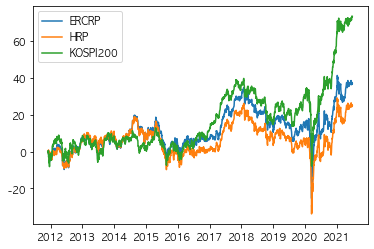

In [8]:
plt.plot(ERCRP_performance_results.Date, ERCRP_performance_results.performance.cumsum() * 100, label="ERCRP")
plt.plot(HRP_performance_results.Date, HRP_performance_results.performance.cumsum() * 100, label="HRP")
plt.plot(benchmark_cummulative_profit, label="KOSPI200")

plt.legend()

In [9]:
performance_metrics(ERCRP_performance_results, HRP_performance_results, benchmark_performance)

,sharp_ratio,annual_average_return,annual_average_risk
ERCRP,1.67,3.93,2.35
HRP,1.16,2.64,2.29
Benchmark,3.09,7.82,2.53


In [10]:
num_asset = 10
rebalancing_period = 21

whole_data = df.reset_index().pivot(index="Date", columns="Name", values="Close").loc["2011-06":"2021-06"]

ERCRP_performance_results = {"Date": [], "portfolio_value": [], "performance": []}
HRP_performance_results = {"Date": [], "portfolio_value": [], "performance": []}

ERCRP_remaining_budget = 100000000
HRP_remaining_budget = 100000000

ERCRP_portfolio_value = 0
HRP_portfolio_value = 0

ERCRP_daily_performance = 0
HRP_daily_performance = 0

for date_number, (today, stock_prices) in enumerate(tqdm(whole_data.iterrows())):
    stock_prices = stock_prices.fillna(0)
    if date_number < 126:
        continue
    
    if date_number % rebalancing_period == 0:
        ERCRP_remaining_budget += ERCRP_portfolio_value
        HRP_remaining_budget += HRP_portfolio_value
        
        start_date = whole_data.index.strftime('%Y-%m-%d').astype(str)[date_number - 121]
        end_date = whole_data.index.strftime('%Y-%m-%d').astype(str)[date_number - 1]
        
        back_data, back_data_pct = get_back_data(start_date, end_date, df, num_asset=num_asset)
        firm_list = back_data.columns.values
        rp_portfolio = RiskParity(back_data_pct)
        rp_portfolio.optimize()
        
        hrp_portfolio = HRP(back_data_pct)
        hrp_portfolio.optimize()
        
        ERCRP_remaining_budget, ERCRP_holding_amount, ERCRP_portfolio_value = generate_portfolio(ERCRP_remaining_budget, rp_portfolio.get_weights, stock_prices[firm_list])
        HRP_remaining_budget, HRP_holding_amount, HRP_portfolio_value = generate_portfolio(HRP_remaining_budget, hrp_portfolio.weights, stock_prices[firm_list])
    else:
        ERCRP_portfolio_value, ERCRP_daily_performance = calc_valuation(ERCRP_holding_amount, ERCRP_portfolio_value, stock_prices[firm_list])
        HRP_portfolio_value, HRP_daily_performance = calc_valuation(HRP_holding_amount, HRP_portfolio_value, stock_prices[firm_list])
        
    ERCRP_performance_results = save_daily_results(ERCRP_performance_results, today, ERCRP_portfolio_value, ERCRP_daily_performance)
    HRP_performance_results = save_daily_results(HRP_performance_results, today, HRP_portfolio_value, HRP_daily_performance)
      
ERCRP_performance_results = pd.DataFrame.from_dict(ERCRP_performance_results)
HRP_performance_results = pd.DataFrame.from_dict(HRP_performance_results)


0it [00:00, ?it/s]/var/folders/nw/x1lqw0rx1mj698bqcgqxhk880000gn/T/ipykernel_5790/1186464116.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.link = linkage(self.distance_mat, 'single')
2485it [02:01, 20.42it/s]


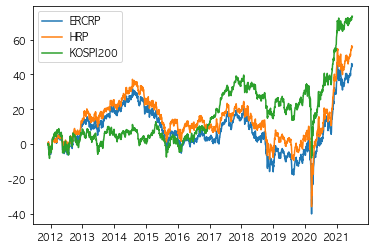

In [11]:
plt.plot(ERCRP_performance_results.Date, ERCRP_performance_results.performance.cumsum() * 100, label="ERCRP")
plt.plot(HRP_performance_results.Date, HRP_performance_results.performance.cumsum() * 100, label="HRP")
plt.plot(benchmark_cummulative_profit, label="KOSPI200")

plt.legend()

In [12]:
performance_metrics(ERCRP_performance_results, HRP_performance_results, benchmark_performance)

,sharp_ratio,annual_average_return,annual_average_risk
ERCRP,1.81,4.87,2.70
HRP,2.22,5.97,2.69
Benchmark,3.09,7.82,2.53
